In [1]:
%matplotlib inline
#%load_ext autoreload
#%autoreload 2
import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats as stats

from DataClass import Data, MassData, Utils
from geo import Vector, Quaternion

# Util

In [2]:
def reject_outliers(data, m=3):
    return data[np.abs(data - np.mean(data)) < m*np.std(data)]

In [3]:
def reject_outliers_with_time(data, time, m=3):
    return data[np.abs(data - np.mean(data)) < m*np.std(data)], time[np.abs(data - np.mean(data)) < m*np.std(data)]

In [4]:
def rad_to_hz(rad, key):
    if key == 'lo':
        hi = 10
        lo = 8
    if key == 'med':
        hi = 11
        lo = 7
    if key == 'hi':
        hi = 12
        lo = 6

    m = (hi - lo) / np.pi
    c = (hi - np.pi) / 2 * m

    return m * rad + c


## Target/Actual Difference

In [5]:
def get_tango_angle(qx, qy, qz, qw):
    tango_orientation = Quaternion(x=qx, y=qy, z=qz, w=qw)
    tango_orientation.normalise()

    # Rotate Tango orientation to fall onto the world axis system
    rotate = Quaternion(vector=Vector(1, 0, 0), angle=np.pi/2)
    rotate.normalise()
    tango_orientation = tango_orientation.multiply(rotate)
    tango_orientation.normalise()

    tango_forward_vector = Vector(0.0, 0.0, -1.0)
    tango_forward_facing_vector = tango_forward_vector.rotate_vector(tango_orientation)

    tilt = np.arctan2(tango_forward_facing_vector.y, tango_forward_facing_vector.z)
    pan = np.arctan2(tango_forward_facing_vector.x, tango_forward_facing_vector.z)
        
    if tilt < -np.pi/2:
        tilt += np.pi
    elif tilt > np.pi/2:
        tilt -= np.pi
    if pan < -np.pi/2:
        pan += np.pi
    elif pan > np.pi/2:
        pan -= np.pi

    return pan, tilt

In [6]:
def get_target_tango_angle_bak(sample, tilt=True):
    
    tango_orientation = Quaternion(x=sample['qx'], y=sample['qy'], z=sample['qz'], w=sample['qw'])
    tango_orientation.normalise()

    # Rotate Tango orientation to fall onto the world axis system
    rotate = Quaternion(vector=Vector(1, 0, 0), angle=np.pi/2)
    rotate.normalise()
    tango_orientation = tango_orientation.multiply(rotate)
    tango_orientation.normalise()

    tango_forward_vector = Vector(0.0, 0.0, -1.0)
    tango_forward_facing_vector = tango_forward_vector.rotate_vector(tango_orientation)
    #tango_forward_facing_vector.normalise()

    vector_to_target = Vector(sample['tx'] - sample['x'], sample['ty'] - sample['z'], sample['tz'] - sample['y'])
    #vector_to_target.normalise()
    #rotate = Quaternion(vector=Vector(0, 0, 1), angle=math.pi)
    #rotate.normalise()
    #vector_to_target = vector_to_target.rotate_vector(rotate)
    #vector_to_target.normalise()

    if tilt:
        tango = np.arctan2(tango_forward_facing_vector.y, tango_forward_facing_vector.z)
        target = np.arctan2(vector_to_target.y, -vector_to_target.z)
    else:
        tango = np.arctan2(tango_forward_facing_vector.x, tango_forward_facing_vector.z)
        #tango = math.atan2(tango_forward_facing_vector.y, np.abs(tango_forward_facing_vector.z))
        target = np.arctan2(vector_to_target.x, -vector_to_target.z)
        
    if tango < -np.pi/2:
        tango += np.pi
    elif tango > np.pi/2:
        tango -= np.pi
    if target < -np.pi/2:
        target += np.pi
    elif target > np.pi/2:
        target -= np.pi

    return target, tango

In [7]:
def get_target_tango_angle(sample, tilt=True):
    
    tango_orientation = Quaternion(x=sample['qx'], y=sample['qy'], z=sample['qz'], w=sample['qw'])
    tango_orientation.normalise()

    # Rotate Tango orientation to fall onto the world axis system
    rotate = Quaternion(vector=Vector(1, 0, 0), angle=np.pi/2)
    rotate.normalise()
    tango_orientation = tango_orientation.multiply(rotate)
    tango_orientation.normalise()

    tango_forward_vector = Vector(0.0, 0.0, -1.0)
    tango_forward_facing_vector = tango_forward_vector.rotate_vector(tango_orientation)
    tango_forward_facing_vector.normalise()

    vector_to_target = Vector(sample['tx'] - sample['x'], sample['ty'] - sample['z'], sample['tz'] - sample['y'])
    vector_to_target.normalise()
    rotate = Quaternion(vector=Vector(0, 0, 1), angle=np.pi)
    rotate.normalise()
    vector_to_target = vector_to_target.rotate_vector(rotate)
    vector_to_target.normalise()

    if tilt:
        tango = np.arctan2(tango_forward_facing_vector.y, -tango_forward_facing_vector.z)
        target = np.arctan2(sample['ty'], -sample['tz'])
    else:
        tango = np.arctan2(tango_forward_facing_vector.x, -tango_forward_facing_vector.z)
        target = np.arctan2(sample['tx'], -sample['tz'])
        
    if tango < -np.pi/2:
        tango += np.pi
    elif tango > np.pi/2:
        tango -= np.pi
    if target < -np.pi/2:
        target += np.pi
    elif target > np.pi/2:
        target -= np.pi

    return target, -tango

In [8]:
def get_guesses_actual(data):
    pans = []
    tilts = []
    for sample in [data.get(i) for i in data.target_indices]:
        target, tango = get_target_tango_angle(sample, False)
        pans.append((target, tango))
        target, tango = get_target_tango_angle(sample, True)
        tilts.append((target, tango))
        
    return pans, tilts

## Angle errors

In [9]:
def get_angle_diff(sample, tilt=True):
    tango_orientation = Quaternion(x=sample['qx'], y=sample['qy'], z=sample['qz'], w=sample['qw'])
    tango_orientation.normalise()

    # Rotate Tango orientation to fall onto the world axis system
    rotate = Quaternion(vector=Vector(1, 0, 0), angle=-np.pi/2)
    rotate.normalise()
    tango_orientation = tango_orientation.multiply(rotate)
    tango_orientation.normalise()

    tango_forward_vector = Vector(0.0, 0.0, -1.0)
    tango_forward_facing_vector = tango_forward_vector.rotate_vector(tango_orientation)
    tango_forward_facing_vector.normalise()

    vector_to_target = Vector(sample['tx'] - sample['x'], sample['ty'] - sample['z'], sample['tz'] - sample['y'])
    vector_to_target.normalise()
    rotate = Quaternion(vector=Vector(0, 0, 1), angle=np.pi)
    rotate.normalise()
    vector_to_target = vector_to_target.rotate_vector(rotate)
    vector_to_target.normalise()

    if tilt:
        tango = Vector(0, tango_forward_facing_vector.y, tango_forward_facing_vector.z)
        tango.normalise()
        target = Vector(0, vector_to_target.y, vector_to_target.z)
        target.normalise()

        angle = tango.inv_dot_product(target)
        
        # Test to see if rotation is positive or negative
        test = tango.cross_product(target)
        if test.x < 0:
            angle = -angle

    else:
        tango = Vector(tango_forward_facing_vector.x, 0, tango_forward_facing_vector.z)
        tango.normalise()
        target = Vector(vector_to_target.x, 0, vector_to_target.z)
        target.normalise()

        angle = tango.inv_dot_product(target)
        
        # Test to see if rotation is positive or negative
        test = tango.cross_product(target)
        if test.y < 0:
            angle = -angle

    return angle

In [10]:
def get_error(data):
    pans = []
    tilts = []
    for sample in [data.get(i) for i in data.target_indices]:
        tilt = get_angle_diff(sample, tilt=True)
        if tilt < -np.pi/2:
            tilt += np.pi
        elif tilt > np.pi/2:
            tilt -= np.pi
        tilts.append(tilt)

        pan = get_angle_diff(sample, tilt=False)
        if pan < -np.pi/2:
            pan += np.pi
        elif pan > np.pi/2:
            pan -= np.pi
        pans.append(pan)
    return (pans, tilts)

# Data import

## Sighted

In [11]:
participant_list = glob.glob('/home/jaycee/workspace/data_processing/target_search/input/cleaned/sighted/*/*/')
data_s = {'med': [], 'lo': [], 'hi': []}

# Import data
for p in participant_list:
    for test in data_s.keys():
        for f in glob.glob(p + 'target/' + test + '/*.csv'):
            data_s[test].append(Data(f, 'target', test))

In [12]:
p_err_s = {'med': [], 'lo': [], 'hi': []}
t_err_s = {'med': [], 'lo': [], 'hi': []}

t_corr_s = {'med': [], 'lo': [], 'hi': []}
p_corr_s = {'med': [], 'lo': [], 'hi': []}

for test in data_s.keys():
    pe = []
    te = []
    pc = []
    tc = []
    for sample in data_s[test]:
        angles = get_error(sample)
        pe.append(angles[0])
        te.append(angles[1])

        angles = get_guesses_actual(sample)
        pc.append(angles[0])
        tc.append(angles[1])
    p_err_s[test] += pe
    t_err_s[test] += te
    p_corr_s[test] += pc
    t_corr_s[test] += tc

## Blind

In [13]:
participant_list = glob.glob('/home/jaycee/workspace/data_processing/target_search/input/cleaned/blind/*/*/')
#print(participant_list)
participant_list = list(filter(lambda x: 'day8' not in x, participant_list))
#print(participant_list)
data_b = {'med': [], 'lo': [], 'hi': []}

# Import data
for p in participant_list:
    for test in data_b.keys():
        for f in glob.glob(p + 'target/' + test + '/*.csv'):
            data_b[test].append(Data(f, 'target', test))

In [14]:
p_err_b = {'med': [], 'lo': [], 'hi': []}
t_err_b = {'med': [], 'lo': [], 'hi': []}

t_corr_b = {'med': [], 'lo': [], 'hi': []}
p_corr_b = {'med': [], 'lo': [], 'hi': []}

for test in data_b.keys():
    pe = []
    te = []
    pc = []
    tc = []
    
    for sample in data_b[test]:
        angles = get_error(sample)
        pe.append(angles[0])
        te.append(angles[1])

        angles = get_guesses_actual(sample)
        pc.append(angles[0])
        tc.append(angles[1])
    p_err_b[test] += pe
    t_err_b[test] += te
    p_corr_b[test] += pc
    t_corr_b[test] += tc

# Results

## Combined

In [15]:
tmp1 = []
tmp2 = []
for d in t_corr_s['lo']:
    f, p = stats.pearsonr([x[0] for x in d], [x[1] for x in d])
    if p < 0.05:
        tmp1.append([x[0] for x in d])
        tmp2.append([x[1] for x in d])
print(stats.pearsonr([x for x in [item for sublist in tmp1 for item in sublist]], [x for x in [item for sublist in tmp2 for item in sublist]]))

(0.4968227098507787, 3.784396772212948e-73)


In [16]:
for test in ['lo', 'med', 'hi']:
    print(test)
    #print([x[0] for x in [item for sublist in p_corr_s[test] for item in sublist]])
    print(stats.pearsonr([x[0] for x in [item for sublist in p_corr_s[test] for item in sublist]], [x[1] for x in [item for sublist in p_corr_s[test] for item in sublist]]))
    print(stats.pearsonr([x[0] for x in [item for sublist in t_corr_s[test] for item in sublist]], [x[1] for x in [item for sublist in t_corr_s[test] for item in sublist]]))
    print(stats.pearsonr([x[0] for x in [item for sublist in p_corr_b[test] for item in sublist]], [x[1] for x in [item for sublist in p_corr_b[test] for item in sublist]]))
    print(stats.pearsonr([x[0] for x in [item for sublist in t_corr_b[test] for item in sublist]], [x[1] for x in [item for sublist in t_corr_b[test] for item in sublist]]))

lo
(0.7458660132763472, 3.2182359345892953e-271)
(0.36387651628402184, 5.555652098279734e-49)
(0.20870276339551694, 0.002095931119919269)
(0.08662874100348941, 0.2057990549300366)
med
(0.7675640627299861, 1.9985945112275611e-292)
(0.4876200930383374, 1.1741110332603201e-90)
(0.24436372920321373, 0.00035106921084866174)
(0.4651012036449094, 1.1432044929370507e-12)
hi
(0.7148909202626925, 9.930795578487454e-244)
(0.48192251059865165, 2.7438395260850807e-91)
(0.48055066952358483, 9.482378028026823e-15)
(0.5388821031450899, 8.453932901712569e-19)


In [17]:
for test in ['lo', 'med', 'hi']:
    print(test)
    print(stats.shapiro([item for sublist in p_err_s[test] for item in sublist]))
    print(stats.shapiro([item for sublist in t_err_s[test] for item in sublist]))
    print(stats.shapiro([item for sublist in p_err_b[test] for item in sublist]))
    print(stats.shapiro([item for sublist in t_err_b[test] for item in sublist]))

lo
(0.9481406211853027, 9.018104513926632e-23)
(0.9687983989715576, 1.1967666473210068e-17)
(0.9859747290611267, 0.032116614282131195)
(0.956031084060669, 3.575347818696173e-06)
med
(0.9503839612007141, 3.9105337062969096e-22)
(0.9760921597480774, 4.089843952192291e-15)
(0.9749287366867065, 0.0008425751584582031)
(0.9285790920257568, 1.3850812052851325e-08)
hi
(0.9259987473487854, 5.07647130319084e-27)
(0.9727762937545776, 1.4165449461124878e-16)
(0.9704338312149048, 9.530883835395798e-05)
(0.9702892899513245, 9.112155385082588e-05)


In [18]:
a = {'lo': 0, 'med': 1, 'hi': 2}

for test in a:
    print(test)
    print('pan sight {} {}'.format(np.mean([item for sublist in p_err_s[test] for item in sublist]), np.std([item for sublist in p_err_s[test] for item in sublist])))
    print('tilt sight {} {}'.format(np.mean([item for sublist in t_err_s[test] for item in sublist]), np.std([item for sublist in t_err_s[test] for item in sublist])))
    print('pan blind {} {}'.format(np.mean([item for sublist in p_err_b[test] for item in sublist]), np.std([item for sublist in p_err_b[test] for item in sublist])))
    print('tilt blind {} {}'.format(np.mean([item for sublist in t_err_b[test] for item in sublist]), np.std([item for sublist in t_err_b[test] for item in sublist])))

lo
pan sight -0.01547664955670045 0.3659481442588174
tilt sight -0.11688101670768399 0.5131318669500585
pan blind -0.0030231925000366766 0.5682018018235498
tilt blind -0.15097177482041702 0.6084560087885363
med
pan sight -0.01413264860815143 0.36752147270084246
tilt sight -0.11052261834891448 0.4068300347017708
pan blind 0.049922512505569575 0.5223160721627323
tilt blind -0.3311756431034342 0.4273426936675097
hi
pan sight -0.03415490028400547 0.3895269418777683
tilt sight -0.14916376088292826 0.44473856943079915
pan blind 0.021012020663925803 0.4208006064240978
tilt blind -0.2740298697794093 0.40285045025890837


In [19]:
a = {'lo': 0, 'med': 1, 'hi': 2}

for test in a:
    print(test)
    print('pan sight {} {}'.format(np.mean(np.abs([item for sublist in p_err_s[test] for item in sublist])), np.std(np.abs([item for sublist in p_err_s[test] for item in sublist]))))
    print('tilt sight {} {}'.format(np.mean(np.abs([item for sublist in t_err_s[test] for item in sublist])), np.std(np.abs([item for sublist in t_err_s[test] for item in sublist]))))
    print('pan blind {} {}'.format(np.mean(np.abs([item for sublist in p_err_b[test] for item in sublist])), np.std(np.abs([item for sublist in p_err_b[test] for item in sublist]))))
    print('tilt blind {} {}'.format(np.mean(np.abs([item for sublist in t_err_b[test] for item in sublist])), np.std(np.abs([item for sublist in t_err_b[test] for item in sublist]))))

lo
pan sight 0.25244103495414455 0.265388573301967
tilt sight 0.42410745558674917 0.3116060831595046
pan blind 0.4775714618707361 0.30787647863237133
tilt blind 0.4903060479141739 0.3906547974901702
med
pan sight 0.25511057436265067 0.2649346325062771
tilt sight 0.3435660654130528 0.24431186012704711
pan blind 0.44972400558782377 0.27028624695388476
tilt blind 0.4229680962782316 0.33674482022259056
hi
pan sight 0.2606333677860104 0.29149278423072317
tilt sight 0.3624664649492282 0.29775876895114795
pan blind 0.3619784116550333 0.21560678299851546
tilt blind 0.36565603092055515 0.32198838776662614


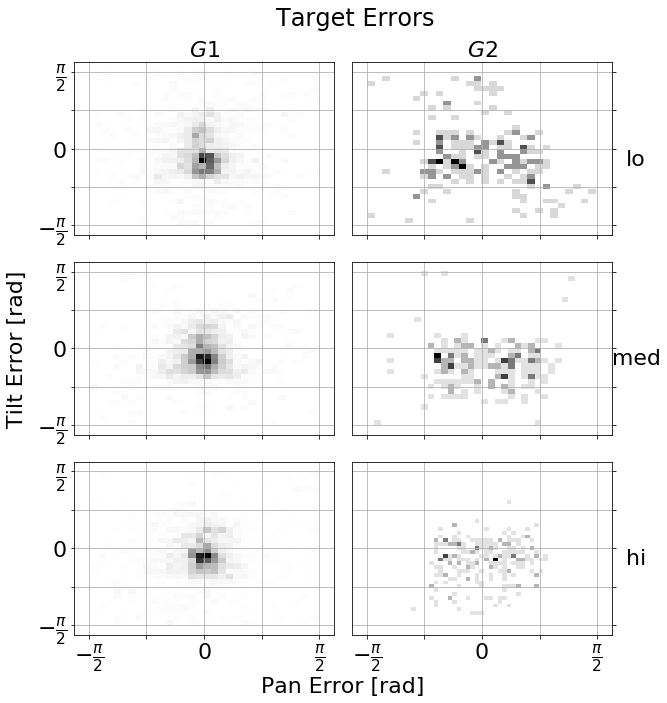

In [20]:
f, ax = plt.subplots(3, 2, sharey=True, sharex=True, figsize=(10, 10))
f.add_subplot(111, frameon=False)

bins = 30
a = {'lo': 0, 'med': 1, 'hi': 2}

for test in a:
    ax[a[test], 0].hist2d([item for sublist in p_err_s[test] for item in sublist], [item for sublist in t_err_s[test] for item in sublist], bins=bins, cmap='Greys')
    ax[a[test], 0].grid()
    ax[a[test], 0].tick_params(axis='both', which='major', labelsize=22)
    
    ax[a[test], 1].yaxis.set_label_position('right')
    ax[a[test], 1].yaxis.tick_right()
    ax[a[test], 1].set_ylabel(test, fontsize=22, rotation=0, labelpad=24)

    ax[a[test], 1].hist2d([item for sublist in p_err_b[test] for item in sublist], [item for sublist in t_err_b[test] for item in sublist], bins=bins, cmap='Greys')
    ax[a[test], 1].grid()
    ax[a[test], 1].tick_params(axis='both', which='major', labelsize=22)
    ax[a[test], 1].set_xticks([-np.pi/2, -np.pi/4, 0, np.pi/4, np.pi/2])
    ax[a[test], 1].set_yticks([-np.pi/2, -np.pi/4, 0, np.pi/4, np.pi/2])

ax[0, 0].set_title(r'$G1$', fontsize=22)

ax[0, 1].set_title(r'$G2$', fontsize=22)
ax[0, 1].set_xlim([-np.pi/2-0.2, np.pi/2+0.2])
ax[0, 1].set_ylim([-np.pi/2-0.2, np.pi/2+0.2])

#ax[1, 0].set_xticklabels([r'$-\frac{\pi}{2}$', r'$-\frac{\pi}{4}$', 0, r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$'])
#ax[1, 0].set_yticklabels([r'$-\frac{\pi}{2}$', r'$-\frac{\pi}{4}$', 0, r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$'])
ax[1, 0].set_xticklabels([r'$-\frac{\pi}{2}$', '', 0, '', r'$\frac{\pi}{2}$'])
ax[1, 0].set_yticklabels([r'$-\frac{\pi}{2}$', '', 0, '', r'$\frac{\pi}{2}$'])

plt.xlabel('Pan Error [rad]', fontsize=22, labelpad=24)
plt.ylabel('Tilt Error [rad]', fontsize=22, labelpad=24)

f.tight_layout()
f.text(0.55, 1.0, 'Target Errors', ha='center', fontsize=24)

plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False, which='both')

plt.show()

## Boxplots

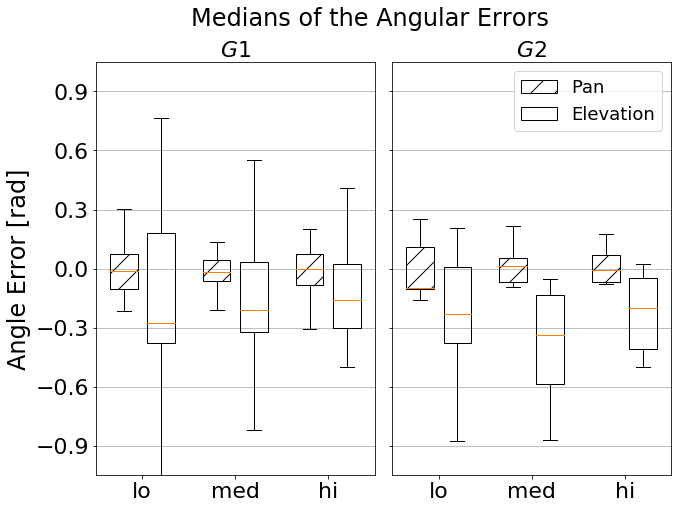

In [21]:
f, ax = plt.subplots(1, 2, sharey=True, figsize=(10, 7))
f.add_subplot(111, frameon=False)

a = {'lo': 0, 'med': 1, 'hi': 2}

bp = ax[0].boxplot([[np.median(x) for x in p_err_s['lo'] if len(x) > 0], [np.median(x) for x in p_err_s['med'] if len(x) > 0], [np.median(x) for x in p_err_s['hi']]], positions=[0.8, 1.8, 2.8], showfliers=False, patch_artist=True)
ax[0].boxplot([[np.median(x) for x in t_err_s['lo'] if len(x) > 0], [np.median(x) for x in t_err_s['med'] if len(x) > 0], [np.median(x) for x in t_err_s['hi']]], positions=[1.2, 2.2, 3.2], showfliers=False)
ax[0].set_ylim([-np.pi/3, np.pi/3])
ax[0].set_xlim([0.5, 3.5])
ax[0].grid(axis='y')
ax[0].set_yticks([-0.9, -0.6, -0.3, 0, 0.3, 0.6, 0.9])
ax[0].set_xticks([1.0, 2.0, 3.0])
ax[0].set_xticklabels(['lo', 'med', 'hi'], fontsize=22)
ax[0].tick_params(axis='both', which='major', labelsize=22)
ax[0].set_title(r'$G1$', fontsize=22)
ax[0].set_ylabel('Angle Error [rad]', fontsize=24)

for box in bp['boxes']:
    box.set(hatch='/')
    box.set(fill=False)

bp0 = ax[1].boxplot([[np.median(x) for x in p_err_b['lo']], [np.median(x) for x in p_err_b['med']], [np.median(x) for x in p_err_b['hi'] if len(x) > 0]], positions=[0.8, 1.8, 2.8], showfliers=False, patch_artist=True)
bp1 = ax[1].boxplot([[np.median(x) for x in t_err_b['lo']], [np.median(x) for x in t_err_b['med']], [np.median(x) for x in t_err_b['hi'] if len(x) > 0]], positions=[1.2, 2.2, 3.2], showfliers=False, patch_artist=True)
ax[1].grid(axis='y')
ax[1].set_xlim([0.5, 3.5])
ax[1].set_xticks([1.0, 2.0, 3.0])
ax[1].set_xticklabels(['lo', 'med', 'hi'], fontsize=22)
ax[1].set_title(r'$G2$', fontsize=22)
#ax[1].legend(['Pan Error', 'Tilt Error'], fontsize=18)

for b0, b1 in zip(bp0['boxes'], bp1['boxes']):
    b0.set(hatch='/')
    b0.set(fill=False)
    b1.set(fill=False)
    b0.set_label('Pan')
ax[1].legend([bp0['boxes'][0], bp1['boxes'][0]], ['Pan', 'Elevation'], fontsize=18)

plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False, which='both')
f.tight_layout()
f.text(0.55, 1.0, 'Medians of the Angular Errors', ha='center', fontsize=24)
plt.show()

/home/jaycee/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaycee/.local/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


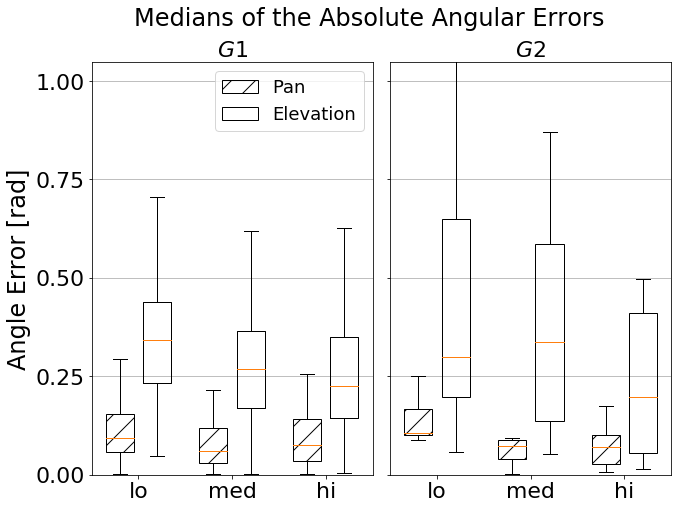

In [156]:
f, ax = plt.subplots(1, 2, sharey=True, figsize=(10, 7))
f.add_subplot(111, frameon=False)

a = {'lo': 0, 'med': 1, 'hi': 2}

bp = ax[0].boxplot([[np.abs(np.median(x)) for x in p_err_s['lo'] if len(x) > 0], [np.abs(np.median(x)) for x in p_err_s['med'] if len(x) > 0], [np.abs(np.median(x)) for x in p_err_s['hi']]], positions=[0.8, 1.8, 2.8], showfliers=False, patch_artist=True)
ax[0].boxplot([[np.abs(np.median(x)) for x in t_err_s['lo'] if len(x) > 0], [np.abs(np.median(x)) for x in t_err_s['med'] if len(x) > 0], [np.abs(np.median(x)) for x in t_err_s['hi']]], positions=[1.2, 2.2, 3.2], showfliers=False)
ax[0].set_ylim([0, np.pi/3])
ax[0].set_xlim([0.5, 3.5])
ax[0].grid(axis='y')
ax[0].set_yticks(np.arange(0, 1.01, 0.25))
ax[0].set_xticks([1.0, 2.0, 3.0])
ax[0].set_xticklabels(['lo', 'med', 'hi'], fontsize=22)
ax[0].tick_params(axis='both', which='major', labelsize=22)
ax[0].set_title(r'$G1$', fontsize=22)
ax[0].set_ylabel('Angle Error [rad]', fontsize=24)

for box in bp['boxes']:
    box.set(hatch='/')
    box.set(fill=False)

bp0 = ax[1].boxplot([[np.abs(np.median(x)) for x in p_err_b['lo']], [np.abs(np.median(x)) for x in p_err_b['med']], [np.abs(np.median(x)) for x in p_err_b['hi'] if ~np.isnan(np.abs(np.median(x)))]], positions=[0.8, 1.8, 2.8], showfliers=False, patch_artist=True)
bp1 = ax[1].boxplot([[np.abs(np.median(x)) for x in t_err_b['lo']], [np.abs(np.median(x)) for x in t_err_b['med']], [np.abs(np.median(x)) for x in t_err_b['hi'] if ~np.isnan(np.abs(np.median(x)))]], positions=[1.2, 2.2, 3.2], showfliers=False, patch_artist=True)
ax[1].grid(axis='y')
ax[1].set_xlim([0.5, 3.5])
ax[1].set_xticks([1.0, 2.0, 3.0])
ax[1].set_xticklabels(['lo', 'med', 'hi'], fontsize=22)
ax[1].set_title(r'$G2$', fontsize=22)
#ax[1].legend(['Pan Error', 'Tilt Error'], fontsize=18)

for b0, b1 in zip(bp0['boxes'], bp1['boxes']):
    b0.set(hatch='/')
    b0.set(fill=False)
    b1.set(fill=False)
    b0.set_label('Pan')
ax[0].legend([bp0['boxes'][0], bp1['boxes'][0]], ['Pan', 'Elevation'], fontsize=18)

plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False, which='both')
f.tight_layout()
f.text(0.55, 1.0, 'Medians of the Absolute Angular Errors', ha='center', fontsize=24)
plt.show()

In [37]:
print('Sighted pan: {}'.format(stats.friedmanchisquare(
    [np.median(x) if len(x) > 0 else 0.0 for x in p_err_s['lo']],
    [np.median(x) if len(x) > 0 else 0.0 for x in p_err_s['med']] + [0.0],
    [np.median(x) if len(x) > 0 else 0.0 for x in p_err_s['hi']] + [0.0]
)))

print('Sighted tilt: {}'.format(stats.friedmanchisquare(
    [np.median(x) if len(x) > 0 else 0.0 for x in t_err_s['lo']],
    [np.median(x) if len(x) > 0 else 0.0 for x in t_err_s['med']] + [0.0],
    [np.median(x) if len(x) > 0 else 0.0 for x in t_err_s['hi']] + [0.0]
)))

print('Blind pan: {}'.format(stats.friedmanchisquare(
    [np.median(x) if len(x) > 0 else 0.0 for x in p_err_b['lo']] + [0.0],
    [np.median(x) if len(x) > 0 else 0.0 for x in p_err_b['med']] + [0.0],
    [np.median(x) if len(x) > 0 else 0.0 for x in p_err_b['hi']]
)))
print('Blind tilt: {}'.format(stats.friedmanchisquare(
    [np.median(x) if len(x) > 0 else 0.0 for x in t_err_b['lo']] + [0.0],
    [np.median(x) if len(x) > 0 else 0.0 for x in t_err_b['med']] + [0.0],
    [np.median(x) if len(x) > 0 else 0.0 for x in t_err_b['hi']]
)))

Sighted pan: FriedmanchisquareResult(statistic=0.07531380753142641, pvalue=0.9630433007452887)
Sighted tilt: FriedmanchisquareResult(statistic=1.263598326359825, pvalue=0.5316344429285511)
Blind pan: FriedmanchisquareResult(statistic=1.1999999999999902, pvalue=0.5488116360940292)
Blind tilt: FriedmanchisquareResult(statistic=0.5142857142857143, pvalue=0.7732577404831906)


In [163]:
print('Sighted pan: {}'.format(stats.friedmanchisquare(
    [np.abs(np.median(x)) for x in p_err_s['lo']][:-1],
    [np.abs(np.median(x)) for x in p_err_s['med']],
    [np.abs(np.median(x)) for x in p_err_s['hi']]
)))

print('Sighted tilt: {}'.format(stats.friedmanchisquare(
    [np.abs(np.median(x)) for x in t_err_s['lo']][:-1],
    [np.abs(np.median(x)) for x in t_err_s['med']],
    [np.abs(np.median(x)) for x in t_err_s['hi']]
)))

print('Blind pan: {}'.format(stats.friedmanchisquare(
    [np.abs(np.median(x)) for x in p_err_b['lo']],
    [np.abs(np.median(x)) for x in p_err_b['med']],
    [np.abs(np.median(x)) for x in p_err_b['hi']  if len(x) > 0]
)))
print('Blind tilt: {}'.format(stats.friedmanchisquare(
    [np.abs(np.median(x)) for x in t_err_b['lo']],
    [np.abs(np.median(x)) for x in t_err_b['med']],
    [np.abs(np.median(x)) for x in t_err_b['hi']  if len(x) > 0]
)))

Sighted pan: FriedmanchisquareResult(statistic=3.491525423728831, pvalue=0.1745118359468142)
Sighted tilt: FriedmanchisquareResult(statistic=12.915254237288082, pvalue=0.001568513193790472)
Blind pan: FriedmanchisquareResult(statistic=4.75, pvalue=0.09301448921066348)
Blind tilt: FriedmanchisquareResult(statistic=2.25, pvalue=0.3246524673583498)


/home/jaycee/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaycee/.local/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [164]:
print('Sighted tilt (lo med): {}'.format(stats.wilcoxon(
    [np.abs(np.median(x)) if len(x) > 0 else 0.0 for x in t_err_s['lo']][:-1],
    [np.abs(np.median(x)) if len(x) > 0 else 0.0 for x in t_err_s['med']]
)))
print('Sighted tilt (lo hi): {}'.format(stats.wilcoxon(
    [np.abs(np.median(x)) if len(x) > 0 else 0.0 for x in t_err_s['lo']][:-1],
    [np.abs(np.median(x)) if len(x) > 0 else 0.0 for x in t_err_s['hi']]
)))
print('Sighted tilt (med hi): {}'.format(stats.wilcoxon(
    [np.abs(np.median(x)) if len(x) > 0 else 0.0 for x in t_err_s['hi']],
    [np.abs(np.median(x)) if len(x) > 0 else 0.0 for x in t_err_s['med']],
)))

Sighted tilt (lo med): WilcoxonResult(statistic=503.0, pvalue=0.0039349894559255645)
Sighted tilt (lo hi): WilcoxonResult(statistic=407.0, pvalue=0.0003086467398434679)
Sighted tilt (med hi): WilcoxonResult(statistic=772.0, pvalue=0.39370295708345915)


In [154]:
for test in ['lo', 'med', 'hi']:
    print(test)
    print(stats.kruskal(
        [np.abs(np.median(x)) if len(x) > 0 else 0 for x in t_err_b[test]],
        [np.abs(np.median(x)) if len(x) > 0 else 0 for x in t_err_s[test]]))
    print(stats.kruskal(
       [np.abs(np.median(x)) if len(x) > 0 else 0 for x in p_err_b[test]],
       [np.abs(np.median(x)) if len(x) > 0 else 0 for x in p_err_s[test]]))

lo
KruskalResult(statistic=0.013043478260897245, pvalue=0.909072872160046)
KruskalResult(statistic=1.775362318840621, pvalue=0.18271983971837805)
med
KruskalResult(statistic=0.8977177797333746, pvalue=0.34339439622147316)
KruskalResult(statistic=0.030285356167567012, pvalue=0.8618443346437806)
hi
KruskalResult(statistic=0.7389666748546517, pvalue=0.389992090177258)
KruskalResult(statistic=1.159502169819035, pvalue=0.28156880995078526)


In [25]:
print('Sighted pan: {}'.format(stats.friedmanchisquare(
    [item for sublist in [x if len(x) > 0 else [0.0] for x in p_err_s['lo']] for item in sublist] + [0.0 for i in range(30)], 
    [item for sublist in [x if len(x) > 0 else [0.0] for x in p_err_s['med']] for item in sublist] + [0.0 for i in range(50)], 
    [item for sublist in [x if len(x) > 0 else [0.0] for x in p_err_s['hi']] for item in sublist]
)))
print('Sighted tilt: {}'.format(stats.friedmanchisquare(
    [item for sublist in [x if len(x) > 0 else [0.0] for x in t_err_s['lo']] for item in sublist] + [0.0 for i in range(30)], 
    [item for sublist in [x if len(x) > 0 else [0.0] for x in t_err_s['med']] for item in sublist] + [0.0 for i in range(50)], 
    [item for sublist in [x if len(x) > 0 else [0.0] for x in t_err_s['hi']] for item in sublist]
)))

print('Blind pan: {}'.format(stats.friedmanchisquare(
    [item for sublist in [x if len(x) > 0 else [0.0] for x in p_err_b['lo']] for item in sublist] + [0.0 for i in range(17)], 
    [item for sublist in [x if len(x) > 0 else [0.0] for x in p_err_b['med']] for item in sublist] + [0.0 for i in range(22)], 
    [item for sublist in [x if len(x) > 0 else [0.0] for x in p_err_b['hi']] for item in sublist]
)))

print('Blind tilt: {}'.format(stats.friedmanchisquare(
    [item for sublist in [x if len(x) > 0 else [0.0] for x in t_err_b['lo']] for item in sublist] + [0.0 for i in range(17)], 
    [item for sublist in [x if len(x) > 0 else [0.0] for x in t_err_b['med']] for item in sublist] + [0.0 for i in range(22)], 
    [item for sublist in [x if len(x) > 0 else [0.0] for x in t_err_b['hi']] for item in sublist]
)))

Sighted pan: FriedmanchisquareResult(statistic=0.9454310623154218, pvalue=0.6233073574826209)
Sighted tilt: FriedmanchisquareResult(statistic=6.820794317079044, pvalue=0.03302808038653196)
Blind pan: FriedmanchisquareResult(statistic=1.323819978046071, pvalue=0.5158650962681905)
Blind tilt: FriedmanchisquareResult(statistic=8.933040614709158, pvalue=0.011487218375279011)


In [26]:
print('Sighted tilt (lo med): {}'.format(stats.wilcoxon(
    [item for sublist in [x if len(x) > 0 else [0.0] for x in t_err_s['lo']] for item in sublist], 
    [item for sublist in [x if len(x) > 0 else [0.0] for x in t_err_s['med']] for item in sublist] + [0.0 for i in range(20)], 
)))
print('Sighted tilt (lo hi): {}'.format(stats.wilcoxon(
    [item for sublist in [x if len(x) > 0 else [0.0] for x in t_err_s['lo']] for item in sublist] + [0.0 for i in range(30)], 
    [item for sublist in [x if len(x) > 0 else [0.0] for x in t_err_s['hi']] for item in sublist], 
)))
print('Sighted tilt (med hi): {}'.format(stats.wilcoxon(
    [item for sublist in [x if len(x) > 0 else [0.0] for x in t_err_s['med']] for item in sublist] + [0.0 for i in range(50)], 
    [item for sublist in [x if len(x) > 0 else [0.0] for x in t_err_s['hi']] for item in sublist], 
)))

Sighted tilt (lo med): WilcoxonResult(statistic=564811.0, pvalue=0.30284347253271204)
Sighted tilt (lo hi): WilcoxonResult(statistic=590729.0, pvalue=0.3992216673167762)
Sighted tilt (med hi): WilcoxonResult(statistic=551101.0, pvalue=0.002080570600016601)


In [27]:
print('Blind tilt (lo med): {}'.format(stats.wilcoxon(
    [item for sublist in [x if len(x) > 0 else [0.0] for x in t_err_b['lo']] for item in sublist] + [0.0 for i in range(17)], 
    [item for sublist in [x if len(x) > 0 else [0.0] for x in t_err_b['med']] for item in sublist] + [0.0 for i in range(22)], 
)))
print('Blind tilt (lo hi): {}'.format(stats.wilcoxon(
    [item for sublist in [x if len(x) > 0 else [0.0] for x in t_err_b['lo']] for item in sublist] + [0.0 for i in range(17)], 
    [item for sublist in [x if len(x) > 0 else [0.0] for x in t_err_b['hi']] for item in sublist], 
)))
print('Blind tilt (med hi): {}'.format(stats.wilcoxon(
    [item for sublist in [x if len(x) > 0 else [0.0] for x in t_err_b['hi']] for item in sublist], 
    [item for sublist in [x if len(x) > 0 else [0.0] for x in t_err_b['med']] for item in sublist] + [0.0 for i in range(22)], 
)))

Blind tilt (lo med): WilcoxonResult(statistic=9295.0, pvalue=0.011245873361513992)
Blind tilt (lo hi): WilcoxonResult(statistic=12658.0, pvalue=0.40291157377527975)
Blind tilt (med hi): WilcoxonResult(statistic=11515.0, pvalue=0.05078350596871445)


## Fitts Relationship

In [28]:
def func_fitts(x, a, b):
    return a + b*x

In [29]:
def fitts_id(x, we):
    return np.log2(np.array(x)/we + 1)

/home/jaycee/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaycee/.local/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jaycee/.local/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/jaycee/.local/lib/python3.6/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/jaycee/.local/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


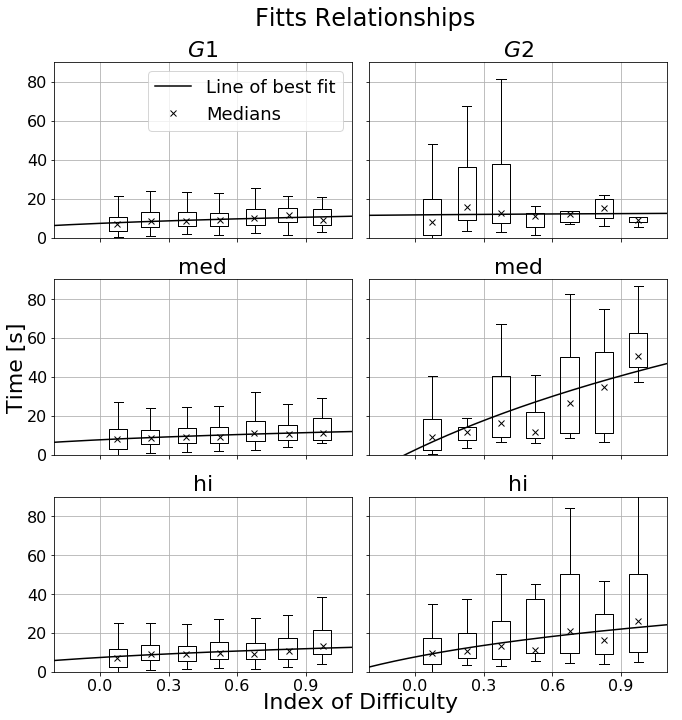

In [166]:
f, ax = plt.subplots(3, 2, sharex=True, sharey=True, figsize=(10, 10))
f.add_subplot(111, frameon=False)

tests = {'lo': ax[0, 0], 'med': ax[1, 0], 'hi': ax[2, 0]}
x = np.arange(-0.9, 2, 0.01)
step = 0.15

for test in tests.keys():
    timediff = []
    anglediff = []
    for dset in data_s[test]:
        timel = []
        ang_distl = []
        df = pd.DataFrame(dset.data)
        for time, qx, qy, qz, qw in df[['time', 'qx', 'qy', 'qz', 'qw']].iloc[[0]+dset.target_indices].itertuples(index=False):
            timel.append(time)
            ang_distl.append(get_tango_angle(qx, qy, qz, qw))

        a, t = reject_outliers_with_time(np.abs(np.diff([np.sqrt(i**2 + y**2) for i, y in ang_distl])), np.diff(timel), m=3)
        timediff+=t.tolist()
        anglediff+=a.tolist()
            
    we = 4.133*np.std(anglediff)

    ids = [fitts_id(x, we) for x in anglediff]

    #bins = np.arange(0, np.max(ids), step)
    bins = np.arange(0, 1.0, step)
    #ind = np.digitize(np.power(2, ids), bins)
    ind = np.digitize(ids, bins)

    timebox = [[] for i in range(len(bins))]
    for i in range(len(timediff)):
        timebox[ind[i]-1].append(timediff[i])
    fopt, pconv = sp.optimize.curve_fit(func_fitts, fitts_id(bins, we), [np.median(t)  if len(t) > 0 else 0 for t in timebox])
    
    #tests[test].plot([i for i in ids], timediff, 'x')
    tests[test].boxplot(timebox, positions=np.round(bins+step/2, 2), showfliers=False, medianprops=dict(linestyle=None, linewidth=0), widths=0.08)
    tests[test].plot(x, fopt[0]+fopt[1]*fitts_id(x, we), 'k', label='Line of best fit')
    tests[test].plot(bins+step/2, [np.median(t) if len(t) > 0 else 0 for t in timebox], 'kx', label='Medians')
    tests[test].set_title(test, fontsize=22)
    tests[test].set_xticks(np.round(np.arange(0, 1, 0.3), 2))
    tests[test].grid()
    tests[test].tick_params(axis='both', which='major', labelsize=16)
tests = {'lo': ax[0, 1], 'med': ax[1, 1], 'hi': ax[2, 1]}

for test in tests.keys():
    timediff = []
    anglediff = []
    for dset in data_b[test]:
        timel = []
        ang_distl = []
        df = pd.DataFrame(dset.data)
        for time, qx, qy, qz, qw in df[['time', 'qx', 'qy', 'qz', 'qw']].iloc[[0]+dset.target_indices].itertuples(index=False):
            timel.append(time)
            ang_distl.append(get_tango_angle(qx, qy, qz, qw))

        a, t = reject_outliers_with_time(np.abs(np.diff([np.sqrt(i**2 + y**2) for i, y in ang_distl])), np.diff(timel), m=3)
        timediff+=t.tolist()
        anglediff+=a.tolist()
            
    we = 4.133*np.std(anglediff)

    ids = [fitts_id(x, we) for x in anglediff]
    
    #bins = np.arange(0, np.max(ids), step)
    bins = np.arange(0, 1.0, step)
    #ind = np.digitize(np.power(2, ids), bins)
    ind = np.digitize(ids, bins)

    timebox = [[] for i in range(len(bins))]
    for i in range(len(timediff)):
        timebox[ind[i]-1].append(timediff[i])
    #print(bins)
    #print(fitts_id(bins+step, we), [np.median(t) for t in timebox if len(t) > 0])
    fopt, pconv = sp.optimize.curve_fit(func_fitts, fitts_id(bins, we), [np.median(t)  if len(t) > 0 else 0 for t in timebox])
    
    #tests[test].plot([i for i in ids], timediff, 'x')
    tests[test].boxplot(timebox, positions=np.round(bins+step/2, 3), showfliers=False, medianprops=dict(linestyle=None, linewidth=0), widths=0.08)
    tests[test].plot(x, fopt[0]+fopt[1]*fitts_id(x, we), 'k', label='Line of best fit')
    tests[test].plot(bins+step/2, [np.median(t) if len(t) > 0 else 0 for t in timebox], 'kx', label='Medians')
    tests[test].set_title(test, fontsize=22)
    tests[test].set_xticks(np.round(np.arange(0, 1, 0.3), 2))
    tests[test].grid()
    tests[test].tick_params(axis='both', which='major', labelsize=16)
    
ax[0, 0].legend(fontsize=18)
ax[0, 0].set_title(r'$G1$', fontsize=22)
ax[0, 1].set_title(r'$G2$', fontsize=22)
#ax[0, 0].set_ylim((0, 50))
ax[1, 0].set_ylim((0, 90))

ax[1, 0].set_xticklabels(np.round(np.arange(0, 1, 0.3), 2))
ax[1, 1].set_xticklabels(np.round(np.arange(0, 1, 0.3), 2))

ax[1, 0].set_xlim((-0.2, 1.1))
ax[1, 1].set_xlim((-0.2, 1.1))

plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False, which='both')
plt.ylabel('Time [s]', fontsize=22)
plt.xlabel('Index of Difficulty', fontsize=22)

f.text(0.55, 1.0, 'Fitts Relationships', ha='center', fontsize=24)
f.tight_layout()
plt.show()

In [170]:
tests = {'lo': 0, 'med': 0, 'hi': 0}
x = np.arange(0, 2, 0.01)
step = 0.15

for test in tests.keys():
    timediff = []
    anglediff = []
    for dset in data_b[test]:
        timel = []
        ang_distl = []
        df = pd.DataFrame(dset.data)
        for time, qx, qy, qz, qw in df[['time', 'qx', 'qy', 'qz', 'qw']].iloc[[0]+dset.target_indices].itertuples(index=False):
            timel.append(time)
            ang_distl.append(get_tango_angle(qx, qy, qz, qw))

        a, t = reject_outliers_with_time(np.abs(np.diff([np.sqrt(i**2 + y**2) for i, y in ang_distl])), np.diff(timel), m=3)
        timediff+=t.tolist()
        anglediff+=a.tolist()
    print(test)

    we = 4.133*np.std(anglediff)
    print(we)

    ids = [fitts_id(x, we) for x in anglediff]

    #bins = np.arange(0, np.max(ids), step)
    bins = np.arange(0, 1.0, step)   
    ind = np.digitize(ids, bins)

    timebox = [[] for i in range(len(bins))]
    for i in range(len(timediff)):
        timebox[ind[i]-1].append(timediff[i])
    x = fitts_id(bins, we)
    fopt, pconv = sp.optimize.curve_fit(func_fitts, x, [np.median(t) if len(t) > 0 else 0 for t in timebox])
    y_fit = fopt[0]+fopt[1]*x
    y_true = [np.median(t) if len(t) > 0 else 0 for t in timebox]
    print(y_fit, y_true)
    print(stats.shapiro(y_fit), stats.shapiro(y_true))
    if stats.shapiro(y_fit)[1] < 0.05 or stats.shapiro(y_true)[1] < 0.05:
        print(stats.spearmanr(y_fit, y_true))
    else:
        print(stats.pearsonr(y_fit, y_true))

lo
1.0903395606597193
[11.69782819 11.84042934 11.96673076 12.08007937 12.18288652 12.27694719
 12.36363362] [8.268109000004188, 15.786211999991792, 12.6894929999944, 11.044894999999997, 11.940073000005214, 15.387327500002584, 9.29242549999617]
(0.9733167886734009, 0.9212619662284851) (0.9444823265075684, 0.6793634295463562)
(0.08413115534849397, 0.8576794407033466)
med
1.2603309381730143
[ 2.50150454 10.44308488 17.58122092 24.06364828 30.00076358 35.47723536
 40.5594256 ] [8.862530999991577, 11.672722256997076, 16.10600999999997, 11.438545701499606, 26.758369999999786, 34.94090199999994, 50.847801000000004]
(0.974245011806488, 0.9272292256355286) (0.8698971271514893, 0.1852433830499649)
(0.8819765443622631, 0.008616840640374858)
hi
0.9239684436111977
[ 7.63422185 10.80379626 13.5583079  15.99398345 18.17703561 20.15497803
 21.96306445] [9.526689500002249, 10.77999800001271, 13.323491500000046, 11.230720999999903, 20.925306664000004, 16.366188999993028, 26.13299200000006]
(0.972020328

/home/jaycee/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaycee/.local/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jaycee/.local/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/jaycee/.local/lib/python3.6/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/jaycee/.local/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


/home/jaycee/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaycee/.local/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jaycee/.local/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/jaycee/.local/lib/python3.6/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/jaycee/.local/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[60, 58, 59]
FriedmanchisquareResult(statistic=40.17573221757321, pvalue=1.8877765881235976e-09)
lo med WilcoxonResult(statistic=403.0, pvalue=0.00016381050775077287)
lo hi WilcoxonResult(statistic=410.0, pvalue=0.00020111681110313547)
hi med WilcoxonResult(statistic=656.0, pvalue=0.08390103960847828)
[8, 8, 9]
FriedmanchisquareResult(statistic=13.542857142857134, pvalue=0.001146056257673944)


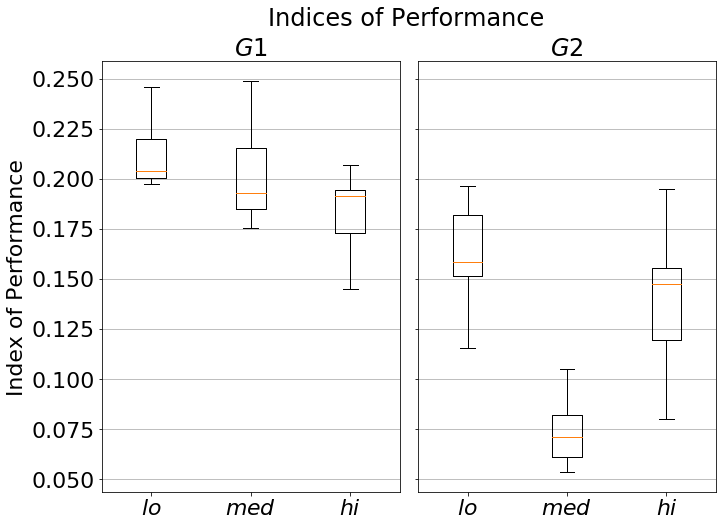

In [172]:
tests = {'lo': 1.015, 'med': 1.017, 'hi': 1.017} # sighted
ips = {'lo': [], 'med': [], 'hi': []}
step = 0.3

for test in tests.keys():
    timediff = []
    anglediff = []
    for dset in data_s[test]:
        timel = []
        ang_distl = []
        df = pd.DataFrame(dset.data)
        for time, qx, qy, qz, qw in df[['time', 'qx', 'qy', 'qz', 'qw']].iloc[[0]+dset.target_indices].itertuples(index=False):
            timel.append(time)
            ang_distl.append(get_tango_angle(qx, qy, qz, qw))

        a, t = reject_outliers_with_time(np.abs(np.diff([np.sqrt(i**2 + y**2) for i, y in ang_distl])), np.diff(timel), m=3)
        timediff+=t.tolist()
        anglediff+=a.tolist()
        #we = 4.133*np.std(anglediff)

        ids = [fitts_id(x, tests[test]) for x in anglediff]
        if len(ids) == 0:
            continue
        #print(ids)
        bins = np.arange(1e-5, np.max(ids), step)
        ind = np.digitize(np.power(2, ids), bins)

        timebox = [[] for i in range(len(bins))]
        for i in range(len(timediff)):
            timebox[ind[i]-1].append(timediff[i])
        #fmedians = [np.median(t) for t in timebox if len(t) > 0].copy()
        #fx = (bins+step).copy()
        #print(fitts_id(bins+step, we), [np.median(t) for t in timebox if len(t) > 0])
        fopt, pconv = sp.optimize.curve_fit(func_fitts, fitts_id(bins+step, we), [np.median(t) if len(t) > 0 else 0.0 for t in timebox ])
        x = fitts_id(bins+step, we)
        #print(x, fopt[0]+fopt[1]*x)
        ips[test].append(np.median(x/(fopt[0]+fopt[1]*x)))
#print(ips)
print([len(ips[test]) for test in ips.keys()])
print(stats.friedmanchisquare(ips['lo'], ips['med']+[0, 0], ips['hi']+[0]))
#print(stats.friedmanchisquare(ips['lo'][:-2], ips['med'], ips['hi'][:-1]))
print('lo med {}'.format(stats.wilcoxon(ips['lo'], ips['med']+[0,0])))
print('lo hi {}'.format(stats.wilcoxon(ips['lo'], ips['hi']+[0])))
print('hi med {}'.format(stats.wilcoxon(ips['hi'], ips['med']+[0])))

f, ax = plt.subplots(1, 2, figsize=(10, 7), sharex=True, sharey=True)

ax[0].boxplot([ips['lo'], ips['med'], ips['hi']], showfliers=False, labels=[r'$lo$', r'$med$', r'$hi$'])
#ax[0].set_title('Indices of Performance', fontsize=24)
ax[0].set_ylabel('Index of Performance', fontsize=22)
ax[0].tick_params(axis='both', which='major', labelsize=22)
ax[0].grid(axis='y')
ax[0].set_title(r'$G1$', fontsize=24)

tests = {'lo': 1.00, 'med': 1.14, 'hi': 0.95} # blind
ips = {'lo': [], 'med': [], 'hi': []}

for test in tests.keys():
    timediff = []
    anglediff = []
    for dset in data_b[test]:
        timel = []
        ang_distl = []
        df = pd.DataFrame(dset.data)
        for time, qx, qy, qz, qw in df[['time', 'qx', 'qy', 'qz', 'qw']].iloc[[0]+dset.target_indices].itertuples(index=False):
            timel.append(time)
            ang_distl.append(get_tango_angle(qx, qy, qz, qw))

        a, t = reject_outliers_with_time(np.abs(np.diff([np.sqrt(i**2 + y**2) for i, y in ang_distl])), np.diff(timel), m=3)
        timediff+=t.tolist()
        anglediff+=a.tolist()
        #we = 4.133*np.std(anglediff)

        ids = [fitts_id(x, tests[test]) for x in anglediff]
        if len(ids) == 0:
            continue
        #print(ids)
        bins = np.arange(1e-5, np.max(ids), step)
        ind = np.digitize(np.power(2, ids), bins)

        timebox = [[] for i in range(len(bins))]
        for i in range(len(timediff)):
            timebox[ind[i]-1].append(timediff[i])
        #fmedians = [np.median(t) for t in timebox if len(t) > 0].copy()
        #fx = (bins+step).copy()
        #print(fitts_id(bins+step, we), [np.median(t) for t in timebox if len(t) > 0])
        fopt, pconv = sp.optimize.curve_fit(func_fitts, fitts_id(bins+step, we), [np.median(t) if len(t) > 0 else 0.0 for t in timebox ])
        x = fitts_id(bins+step, we)
        #print(x, fopt[0]+fopt[1]*x)
        ips[test].append(np.median(x/(fopt[0]+fopt[1]*x)))
print([len(ips[test]) for test in ips.keys()])
print(stats.friedmanchisquare(ips['lo']+[0], ips['med']+[0], ips['hi']))
#print(stats.friedmanchisquare(ips['lo'], ips['med'], ips['hi'][:-1]))
        
ax[1].boxplot([ips['lo'], ips['med'], ips['hi']], showfliers=False, labels=[r'$lo$', r'$med$', r'$hi$'])
#ax[0].set_title('Indices of Performance', fontsize=24)
#ax[0].set_ylabel('Index of Performance', fontsize=22)
#ax[0].tick_params(axis='both', which='major', labelsize=16)
ax[1].grid(axis='y')
ax[1].tick_params(axis='both', which='major', labelsize=22)
ax[1].set_title(r'$G2$', fontsize=24)

f.text(0.55, 1.0, 'Indices of Performance', ha='center', fontsize=24)
f.tight_layout()
plt.show()

/home/jaycee/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaycee/.local/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jaycee/.local/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/jaycee/.local/lib/python3.6/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/jaycee/.local/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[60, 58, 59]
FriedmanchisquareResult(statistic=50.62068965517244, pvalue=1.0182558323509833e-11)
lo med WilcoxonResult(statistic=99.0, pvalue=4.71058503776625e-09)
lo hi WilcoxonResult(statistic=88.0, pvalue=1.790702640375869e-09)
hi med WilcoxonResult(statistic=832.0, pvalue=0.8556257494372784)
FriedmanchisquareResult(statistic=14.25, pvalue=0.000804733010124613)
lo med WilcoxonResult(statistic=0.0, pvalue=0.011718685599768628)
lo hi WilcoxonResult(statistic=1.0, pvalue=0.017290280592906253)
hi med WilcoxonResult(statistic=0.0, pvalue=0.011718685599768628)


/home/jaycee/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:2388: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")
/home/jaycee/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:2388: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")
/home/jaycee/.local/lib/python3.6/site-packages/scipy/stats/morestats.py:2388: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")


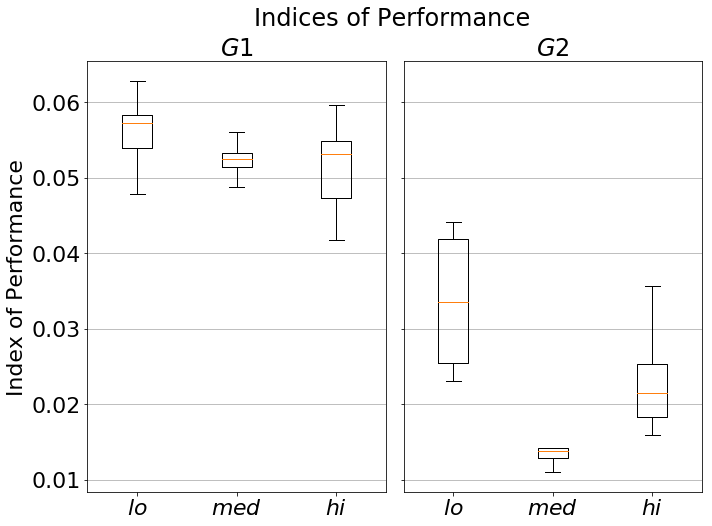

lo
KruskalResult(statistic=20.009057971014528, pvalue=7.70761913807569e-06)
0.05603658117367922 0.005066141095120224
0.033600360225293474 0.008547349994830521
med
KruskalResult(statistic=20.776553106212397, pvalue=5.161098158038887e-06)
0.053345721173572065 0.008393243333583015
0.01374923334519211 0.00204982697909042
hi
KruskalResult(statistic=22.39697213759995, pvalue=2.217232872775389e-06)
0.050854493613548254 0.006962756888498539
0.022120335162521158 0.005903396037040254


In [188]:
tests = {'lo': 1.015, 'med': 1.017, 'hi': 1.017} # sighted
ips_s = {'lo': [], 'med': [], 'hi': []}
step = 0.15

for test in tests.keys():
    timediff = []
    anglediff = []
    for dset in data_s[test]:
        timel = []
        ang_distl = []
        df = pd.DataFrame(dset.data)
        for time, qx, qy, qz, qw in df[['time', 'qx', 'qy', 'qz', 'qw']].iloc[[0]+dset.target_indices].itertuples(index=False):
            timel.append(time)
            ang_distl.append(get_tango_angle(qx, qy, qz, qw))

        a, t = reject_outliers_with_time(np.abs(np.diff([np.sqrt(i**2 + y**2) for i, y in ang_distl])), np.diff(timel), m=3)
        timediff+=t.tolist()
        anglediff+=a.tolist()
        #we = 4.133*np.std(anglediff)
        we = tests[test]

        #ids = [fitts_id(x, tests[test]) for x in anglediff]
        ids = [fitts_id(x, we) for x in anglediff]
        if len(ids) == 0:
            continue
        #print(ids)
        bins = np.arange(0, 1, step)
        ind = np.digitize(ids, bins)

        timebox = [[] for i in range(len(bins))]
        for i in range(len(timediff)):
            timebox[ind[i]-1].append(timediff[i])
        #fmedians = [np.median(t) for t in timebox if len(t) > 0].copy()
        #fx = (bins+step).copy()
        #print(fitts_id(bins+step, we), [np.median(t) for t in timebox if len(t) > 0])
        fopt, pconv = sp.optimize.curve_fit(func_fitts, fitts_id(bins, we), [np.median(t) if len(t) > 0 else 0.0 for t in timebox ])
        #x = fitts_id(bins, tests[test])
        x = fitts_id(bins, we)
        #print(x, fopt[0]+fopt[1]*x)
        ips_s[test].append(np.median(x/(fopt[0]+fopt[1]*x)))
#print(ips)
print([len(ips_s[test]) for test in ips_s.keys()])
print(stats.friedmanchisquare(ips_s['lo'][:-2], ips_s['med'], ips_s['hi'][:-1]))
#print(stats.kruskal(ips['lo'], ips['med'], ips['hi']))
#print(stats.friedmanchisquare(ips['lo'][:-2], ips['med'], ips['hi'][:-1]))
print('lo med {}'.format(stats.wilcoxon(ips_s['lo'][:-2], ips_s['med'])))
print('lo hi {}'.format(stats.wilcoxon(ips_s['lo'][:-1], ips_s['hi'])))
print('hi med {}'.format(stats.wilcoxon(ips_s['hi'][:-1], ips_s['med'])))

f, ax = plt.subplots(1, 2, figsize=(10, 7), sharex=True, sharey=True)

ax[0].boxplot([ips_s['lo'], ips_s['med'], ips_s['hi']], showfliers=False, labels=[r'$lo$', r'$med$', r'$hi$'])
#ax[0].set_title('Indices of Performance', fontsize=24)
ax[0].set_ylabel('Index of Performance', fontsize=22)
ax[0].tick_params(axis='both', which='major', labelsize=22)
ax[0].grid(axis='y')
ax[0].set_title(r'$G1$', fontsize=24)

tests = {'lo': 1.09, 'med': 1.26, 'hi': 0.92} # blind
ips_b = {'lo': [], 'med': [], 'hi': []}

for test in tests.keys():
    timediff = []
    anglediff = []
    for dset in data_b[test]:
        timel = []
        ang_distl = []
        df = pd.DataFrame(dset.data)
        for time, qx, qy, qz, qw in df[['time', 'qx', 'qy', 'qz', 'qw']].iloc[[0]+dset.target_indices].itertuples(index=False):
            timel.append(time)
            ang_distl.append(get_tango_angle(qx, qy, qz, qw))

        a, t = reject_outliers_with_time(np.abs(np.diff([np.sqrt(i**2 + y**2) for i, y in ang_distl])), np.diff(timel), m=3)
        timediff+=t.tolist()
        anglediff+=a.tolist()
        #we = 4.133*np.std(anglediff)
        we = tests[test]

        #ids = [fitts_id(x, tests[test]) for x in anglediff]
        ids = [fitts_id(x, we) for x in anglediff]
        if len(ids) == 0:
            continue
        #print(ids)
        bins = np.arange(0, 1, step)
        ind = np.digitize(ids, bins)

        timebox = [[] for i in range(len(bins))]
        for i in range(len(timediff)):
            timebox[ind[i]-1].append(timediff[i])
        fopt, pconv = sp.optimize.curve_fit(func_fitts, fitts_id(bins, we), [np.median(t) if len(t) > 0 else 0.0 for t in timebox ])
        #x = fitts_id(bins, tests[test])
        x = fitts_id(bins, we)
        ips_b[test].append(np.median(x/(fopt[0]+fopt[1]*x)))
#print([ips[test] for test in ips.keys()])
print(stats.friedmanchisquare(ips_b['lo'], ips_b['med'], ips_b['hi'][:-1]))
print('lo med {}'.format(stats.wilcoxon(ips_b['lo'], ips_b['med'])))
print('lo hi {}'.format(stats.wilcoxon(ips_b['lo'], ips_b['hi'][:-1])))
print('hi med {}'.format(stats.wilcoxon(ips_b['hi'][:-1], ips_b['med'])))
#print(stats.friedmanchisquare(ips['lo'], ips['med'], ips['hi'][:-1]))
        
ax[1].boxplot([ips_b['lo'], ips_b['med'], ips_b['hi']], showfliers=False, labels=[r'$lo$', r'$med$', r'$hi$'])
#ax[0].set_title('Indices of Performance', fontsize=24)
#ax[0].set_ylabel('Index of Performance', fontsize=22)
#ax[0].tick_params(axis='both', which='major', labelsize=16)
ax[1].grid(axis='y')
ax[1].tick_params(axis='both', which='major', labelsize=22)
ax[1].set_title(r'$G2$', fontsize=24)

f.text(0.55, 1.0, 'Indices of Performance', ha='center', fontsize=24)
f.tight_layout()
plt.show()

for test in ['lo', 'med', 'hi']:
    print(test)
    print(stats.kruskal(ips_b[test], ips_s[test]))
    print(np.mean(ips_s[test]), np.std(ips_s[test]))
    print(np.mean(ips_b[test]), np.std(ips_b[test]))

In [ ]:
datasets = {}
glob_pan = []
glob_tilt = []
for key in ['lo', 'med', 'hi']:
    pan = []
    tilt = []
    for dset in data_b[key]:
        code = dset.file.split('/')[10]
        if code not in datasets.keys():
            datasets[code] = {}
        datasets[code][key] = {}
        datasets[code][key]['pan'] = []
        datasets[code][key]['tilt'] = []
        pans, tilts = get_error(dset)
        if len(pans) != 0 and len(tilts) != 0:
            datasets[code][key]['pan'].append(np.median(pans))
            datasets[code][key]['tilt'].append(np.median(np.array(tilts)))
            pan.append(np.median(pans))
            tilt.append(np.median(tilts))
            # pans.append(np.median(pan))
            # tilts.append(np.median(tilt))
    glob_pan.append(pan)
    glob_tilt.append(tilt)
pans = []
tilts = []
for code in datasets.keys():
    pan = []
    tilt = []
    for key in datasets[code].keys():
        if len(datasets[code][key]['tilt']) != 0:
            pan.append(datasets[code][key]['pan'])
            tilt.append(datasets[code][key]['tilt'][0])
    tilts.append(tilt)
    pans.append(pan)

f, ax = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(14, 7))
f.add_subplot(111, frameon=False)

hatch = {'lo': '/', 'med': 'x', 'hi': 'o'}
for key in ['lo', 'med', 'hi']:
    nbins = 5
    data = [datasets[code][key]['tilt'][0] if len(datasets[code][key]['tilt']) != 0 else 0.0 for code in datasets.keys()]
    data = [rad_to_hz(data[i], key) for i in range(len(data))]
    # hist, bins = np.histogram(np.log2(data), normed=False, bins=int(nbins))
    hist, bins = np.histogram(data, density=False, bins=int(nbins))
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    nsamples = len(data)*3
    ax[0].bar(center, hist/nsamples, align='center', width=width, label=key, fill=False, hatch=hatch[key])
ax[0].plot([2**(1/0.2854498373089882), 2**(1/0.2854498373089882)], [0, 0.18], 'k--', label='Median Cut-Off')
ax[0].tick_params(axis='both', which='major', labelsize=22)
ax[0].set_ylabel('Number of Samples [normalised]', fontsize=24)
#ax[0].set_yticks(np.arange(0, 0.176, 0.025))
#ax[0].set_yticklabels(np.arange(0, 0.176, 0.025))
ax[0].set_title(r'$G1$', fontsize=22)
ax[0].legend(fontsize=18)
ax[0].grid()

glob_pan = []
glob_tilt = []
for key in ['lo', 'med', 'hi']:
    pan = []
    tilt = []
    for dset in data_s[key]:
        code = dset.file.split('/')[10]
        if code not in datasets.keys():
            datasets[code] = {}
        datasets[code][key] = {}
        datasets[code][key]['pan'] = []
        datasets[code][key]['tilt'] = []
        pans, tilts = get_error(dset)
        if len(pans) != 0 and len(tilts) != 0:
            datasets[code][key]['pan'].append(np.median(pans))
            datasets[code][key]['tilt'].append(np.median(np.array(tilts)))
            pan.append(np.median(pans))
            tilt.append(np.median(tilts))
            # pans.append(np.median(pan))
            # tilts.append(np.median(tilt))
    glob_pan.append(pan)
    glob_tilt.append(tilt)
pans = []
tilts = []
for code in datasets.keys():
    pan = []
    tilt = []
    for key in datasets[code].keys():
        if len(datasets[code][key]['tilt']) != 0:
            pan.append(datasets[code][key]['pan'])
            tilt.append(datasets[code][key]['tilt'][0])
    tilts.append(tilt)
    pans.append(pan)

hatch = {'lo': '/', 'med': 'x', 'hi': 'o'}
for key in ['lo', 'med', 'hi']:
    nbins = 5
    data = [datasets[code][key]['tilt'][0] if len(datasets[code][key]['tilt']) != 0 else 0.0 for code in datasets.keys()]
    data = [rad_to_hz(data[i], key) for i in range(len(data))]
    # hist, bins = np.histogram(np.log2(data), normed=False, bins=int(nbins))
    hist, bins = np.histogram(data, density=False, bins=int(nbins))
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    nsamples = len(data)*3
    ax[1].bar(center, hist/nsamples, align='center', width=width, label=key, fill=False, hatch=hatch[key])
ax[1].plot([2**(1/0.3506489946182825), 2**(1/0.3506489946182825)], [0, 0.18], 'k--')
ax[1].tick_params(axis='both', which='major', labelsize=22)
ax[1].set_title(r'$G2$', fontsize=22)
ax[1].grid()

f.text(0.55, -0.01, 'Sound Frequency [Hz]', ha='center', fontsize=24)
f.text(0.55, 1.0, '75% Cut-Off Thresholds', ha='center', fontsize=24)
f.tight_layout()
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False, which='both')
plt.show()